# ***Importing libraries***

In [1]:
!pip install --upgrade openpyxl
!pip install pyspark
!pip install numpy
!pip install scikit-surprise
import pandas as pd
import numpy as np
import io
import os
import json
import gzip
from google.colab import files
from urllib.request import urlopen
from sklearn.metrics import pairwise_distances,mean_squared_error
from sklearn.neighbors import NearestNeighbors
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import split
from surprise import Dataset,Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from collections import defaultdict

     |████████████████████████████████| 281.4 MB 28 kB/s 
     |████████████████████████████████| 198 kB 56.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=649364b2be8c3ef09fa1025e9b5f42797495734970262dee2abd9ebf8e0a668a
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
     |████████████████████████████████| 11.8 MB 6.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630211 sha256=814601922d1d170090a7db126cc2b6fc813ca603c9d364ef5086bf917525d2c2
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


# ***Reading the raw files into colab***

In [4]:
uploaded = files.upload()
uploaded_meta= files.upload()

Saving All_Beauty_5.json to All_Beauty_5.json


Saving All_Beauty_metadata.json.gz to All_Beauty_metadata.json.gz


# ***Reading the json file and converting them to a dataframe***

In [5]:
pd.set_option('display.max_columns', None)
df = pd.read_json(io.StringIO(uploaded.get('All_Beauty_5.json').decode('utf-8')),lines=True)
df_meta = pd.read_json(io.StringIO(uploaded.get('All_Beauty_metadata.json.gz')),lines=True)

In [6]:
df.shape

(5269, 12)

*Load the meta data from the zipped file*

In [7]:
data = []
with gzip.open('All_Beauty_metadata.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

32892
{'category': [], 'tech1': '', 'description': ["Loud 'N Clear Personal Sound Amplifier allows you to turn up the volume on what people around you are saying, listen at the level you want without disturbing others, hear a pin drop from across the room."], 'fit': '', 'title': "Loud 'N Clear&trade; Personal Sound Amplifier", 'also_buy': [], 'tech2': '', 'brand': 'idea village', 'feature': [], 'rank': '2,938,573 in Beauty & Personal Care (', 'also_view': [], 'details': {'ASIN: ': '6546546450'}, 'main_cat': 'All Beauty', 'similar_item': '', 'date': '', 'price': '', 'asin': '6546546450', 'imageURL': [], 'imageURLHighRes': []}


*Convert metadata file list into a pandas dataframe*

In [8]:

df_meta = pd.DataFrame.from_dict(data)
print(len(df_meta))

32892


In [9]:
df_meta.shape

(32892, 19)

# ***Exploratory Data Analyis***

In [10]:
df.dtypes

overall            int64
verified            bool
reviewTime        object
reviewerID        object
asin              object
style             object
reviewerName      object
reviewText        object
summary           object
unixReviewTime     int64
vote              object
image             object
dtype: object

In [11]:
df.describe(include='all')

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
count,5269.000000,5269,5269,5269,5269,4624,5269,5264,5264,5.269000e+03,552,98
unique,NaN,2,883,991,85,408,905,1363,1011,NaN,24,25
top,NaN,True,"07 14, 2016",AKJHHD5VEH7VG,B0012Y0ZG2,{'Size:': ' Small'},Amazon Customer,Great product,Five Stars,NaN,2,[https://images-na.ssl-images-amazon.com/image...
freq,NaN,4280,33,12,1794,202,362,15,1455,NaN,238,5
mean,4.771873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.441506e+09,NaN,NaN
std,0.743204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.473127e+07,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.095725e+09,NaN,NaN
25%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.407024e+09,NaN,NaN
50%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.445645e+09,NaN,NaN
75%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.481674e+09,NaN,NaN


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5269 entries, 0 to 5268
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         5269 non-null   int64 
 1   verified        5269 non-null   bool  
 2   reviewTime      5269 non-null   object
 3   reviewerID      5269 non-null   object
 4   asin            5269 non-null   object
 5   style           4624 non-null   object
 6   reviewerName    5269 non-null   object
 7   reviewText      5264 non-null   object
 8   summary         5264 non-null   object
 9   unixReviewTime  5269 non-null   int64 
 10  vote            552 non-null    object
 11  image           98 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 458.1+ KB


In [13]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32892 entries, 0 to 32891
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         32892 non-null  object
 1   tech1            32892 non-null  object
 2   description      32892 non-null  object
 3   fit              32892 non-null  object
 4   title            32892 non-null  object
 5   also_buy         32892 non-null  object
 6   tech2            32892 non-null  object
 7   brand            32892 non-null  object
 8   feature          32892 non-null  object
 9   rank             32892 non-null  object
 10  also_view        32892 non-null  object
 11  details          32892 non-null  object
 12  main_cat         32892 non-null  object
 13  similar_item     32892 non-null  object
 14  date             32892 non-null  object
 15  price            32892 non-null  object
 16  asin             32892 non-null  object
 17  imageURL         32892 non-null

# ***Merging review and metadata file for All Beauty category to create a single dataframe***

In [14]:
merged_df = pd.DataFrame(pd.merge(df, df_meta, on='asin'))
merged_df.shape

(5767, 30)

In [15]:
duplicate_columns = ['reviewerID', 'asin']

# Get a dataframe consisting only of reviews that are duplicated
duplicates = merged_df[merged_df.duplicated(subset=duplicate_columns,keep=False)].sort_values(duplicate_columns)
duplicates #this gives the number of duplicated rows where 'reviewerID', 'asin' are same

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,imageURL,imageURLHighRes
3497,5,True,"07 6, 2014",A105A034ZG9EHO,B0012Y0ZG2,{'Size:': ' 180'},K. Mras,yum,Five Stars,1404604800,NaN,NaN,[],,"[, , <b>Bath & Body Works Ile De Tahiti Moana ...",,Bath &amp; Body Works Ile De Tahiti Moana Coco...,[],,Bath & Body Works,[],"1,279,015 in Beauty & Personal Care (",[],"{' Item Weight: ': '8.5 ounces', 'Shi...",All Beauty,,,,[],[]
4393,5,True,"07 6, 2014",A105A034ZG9EHO,B0012Y0ZG2,{'Size:': ' 180'},K. Mras,yum,Five Stars,1404604800,NaN,NaN,[],,"[, , <b>Bath & Body Works Ile De Tahiti Moana ...",,Bath &amp; Body Works Ile De Tahiti Moana Coco...,[],,Bath & Body Works,[],"1,279,015 in Beauty & Personal Care (",[],"{' Item Weight: ': '8.5 ounces', 'Shi...",All Beauty,,,,[],[]
3615,5,True,"08 13, 2013",A10JB7YPWZGRF4,B0012Y0ZG2,{'Size:': ' 45'},Amazon Customer,I continually get compliments on how wonderful...,Heaven !,1376352000,NaN,NaN,[],,"[, , <b>Bath & Body Works Ile De Tahiti Moana ...",,Bath &amp; Body Works Ile De Tahiti Moana Coco...,[],,Bath & Body Works,[],"1,279,015 in Beauty & Personal Care (",[],"{' Item Weight: ': '8.5 ounces', 'Shi...",All Beauty,,,,[],[]
4511,5,True,"08 13, 2013",A10JB7YPWZGRF4,B0012Y0ZG2,{'Size:': ' 45'},Amazon Customer,I continually get compliments on how wonderful...,Heaven !,1376352000,NaN,NaN,[],,"[, , <b>Bath & Body Works Ile De Tahiti Moana ...",,Bath &amp; Body Works Ile De Tahiti Moana Coco...,[],,Bath & Body Works,[],"1,279,015 in Beauty & Personal Care (",[],"{' Item Weight: ': '8.5 ounces', 'Shi...",All Beauty,,,,[],[]
2696,4,False,"05 27, 2015",A10M2MLE2R0L6K,B000VV1YOY,"{'Size:': ' 1 count', 'Color:': ' Millionails ...",Booklover,Very nice product. Makes a very nice base for...,Very nice product,1432684800,NaN,NaN,[],,[apricot cuticle oil helps protect from drynes...,,"essie nail polish, cuticle care, primers and f...",[],,,[],"90,177 in Beauty & Personal Care (","[B01N5OZ410, B07J31QMYS, B075M32PQ4, B01M35FGL...",{' Product Dimensions: ': '1.5 x 2 x ...,All Beauty,,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,5,True,"12 20, 2013",AZJMUP77WBQZQ,B00006L9LC,{'Size:': ' 329'},S. Foote,THIS WAS A GIFT PURCHASED LAST YEAR FOR MY DAU...,GIFT,1387497600,NaN,NaN,[],,[<P><STRONG>Restores Moisture to Dehydrated Ha...,,Citre Shine Moisture Burst Shampoo - 16 fl oz,"[B07CSVCGZV, B07KMGC13Z, B0793XJ4WW, B01N7U1HB...",,Citre Shine,[],"1,693,702 in Beauty & Personal Care (",[],"{'ASIN: ': 'B00006L9LC', 'UPC:': '795827187965...",All Beauty,,,$23.00,[],[]
3559,5,True,"12 20, 2013",AZJMUP77WBQZQ,B0012Y0ZG2,{'Size:': ' 329'},S. Foote,THIS WAS A GIFT PURCHASED LAST YEAR FOR MY DAU...,GIFT,1387497600,NaN,NaN,[],,"[, , <b>Bath & Body Works Ile De Tahiti Moana ...",,Bath &amp; Body Works Ile De Tahiti Moana Coco...,[],,Bath & Body Works,[],"1,279,015 in Beauty & Personal Care (",[],"{' Item Weight: ': '8.5 ounces', 'Shi...",All Beauty,,,,[],[]
4455,5,True,"12 20, 2013",AZJMUP77WBQZQ,B0012Y0ZG2,{'Size:': ' 329'},S. Foote,THIS WAS A GIFT PURCHASED LAST YEAR FOR MY DAU...,GIFT,1387497600,NaN,NaN,[],,"[, , <b>Bath & Body Works Ile De Tahiti Moana ...",,Bath &amp; Body Works Ile De Tahiti Moana Coco...,[],,Bath & Body Works,[],"1,279,015 in Beauty & Personal Care (",[],"{' Item Weight: ': '8.5 ounces', 'Shi...",All Beauty,,,,[],[]
3458,5,True,"09 28, 2014",AZRD4IZU6TBFV,B0012Y0ZG2,{'Size:': ' 200'},Norma Gandy,Like this product very much..it smells great.,Five Stars,1411862400,NaN,NaN,[],,"[, , <b>Bath & Body Works Ile De Tahiti Moana ...",,Bath &amp; Body Works Ile De Tahiti Moana Coco...,[],,Bath & Body Works,[],"1,279,015 in Beauty & Personal Care (",[],"{' Ite

In [16]:
reviews = (merged_df.sort_values(['reviewerID', 'asin', 'unixReviewTime'], ascending=[False, False, True]).drop_duplicates(subset=duplicate_columns, keep='last'))
reviews.shape

(4092, 30)

In [17]:
# from google.colab import files
# reviews.to_csv('reviews.csv') 
# files.download('reviews.csv')

In [18]:
pd.unique(reviews['reviewerID']).shape

(991,)

# ***Data Visualization Hidden***

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


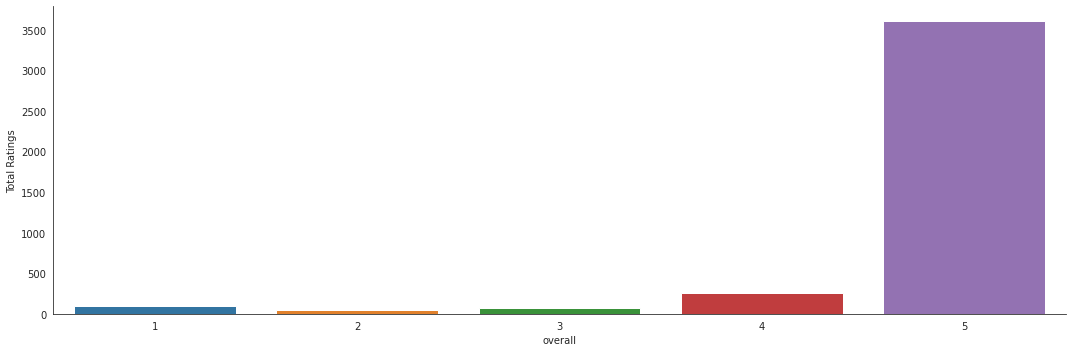

In [19]:
import seaborn as sns
with sns.axes_style('white'):
    g = sns.factorplot("overall", data=reviews, aspect=3.0,kind='count')
    g.set_ylabels("Total Ratings")

Interference: We could see that most products that are sold in this cateogry has got best ratings(5) from the reviewers. Thay are satisfied and more likely to buy these products in the future from Amazon.

In [20]:
reviews['year'] = pd.DatetimeIndex(reviews['reviewTime']).year

reviews['year'].head(10)

4354    2014
2463    2014
1619    2014
1226    2014
5170    2013
4455    2013
2565    2013
869     2013
5007    2015
4127    2015
Name: year, dtype: int64

In [21]:
no_of_rated_products_per_user = reviews.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head(5)

reviewerID
A1UQBFCERIP7VJ    10
A3S3R88HA0HZG3     7
AOEUN9718KVRD      7
A22CW0ZHY3NJH8     7
A2LW5AL0KQ9P1M     7
Name: overall, dtype: int64

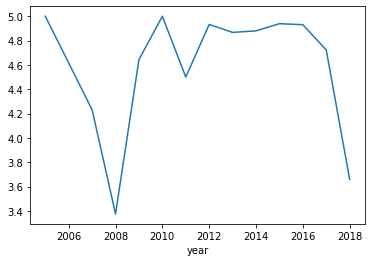

In [22]:
#plot mean and median rating over the years
import matplotlib.pyplot as plt
import numpy as np

mean_of_rated_products_per_user = reviews.groupby(by=reviews['year'].sort_values(ascending=False))['overall'].mean()
mean_of_rated_products_per_user.plot()

Interference: The average ratings have been quite good for all the products but we can see that it took a fall in 2007/08, may be due to fake or poor quality products. It is also cpmaparetively low in recents year as now more customers are buying and reviewing products and they expect high stantards from the product makers on Amazon.

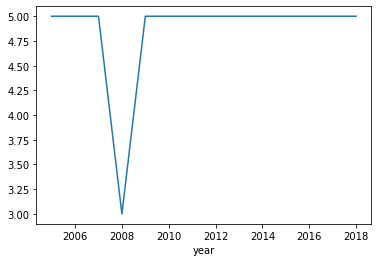

In [23]:
med_of_rated_products_per_user = reviews.groupby(by=reviews['year'].sort_values(ascending=False))['overall'].median()
med_of_rated_products_per_user.plot()

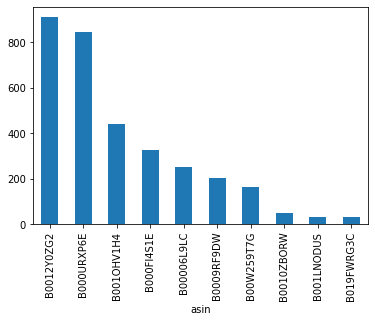

In [24]:
#products with highest ratings

df2 = reviews.groupby(by=df['asin'])['overall'].count().sort_values(ascending=False)
df2.head(10).plot(kind = 'bar')

The above mentioned products have the highest ratings as these must be most sold items on the Amazon.

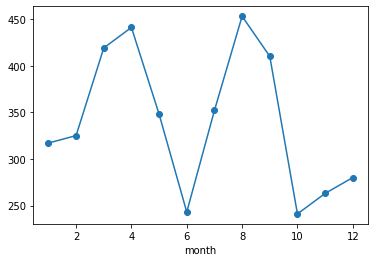

In [25]:
#rating trends over the months

import matplotlib.pyplot as plt
import numpy as np
reviews['month'] = pd.DatetimeIndex(reviews['reviewTime']).month
month = reviews.groupby(by=reviews['month'].sort_values(ascending=False))['overall'].count()
month.plot(marker='o')

Interference: We can observe that there are two highs(mar-apr & aug-sept) and two lows(june & oct) through the year in the ratings given by the users.

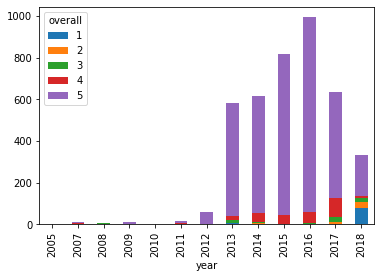

In [26]:
#Year wise count of Amazon products with particular rating

yearratings = reviews.groupby(['year', 'overall'])['overall'].count().unstack('overall').fillna(0)
yearratings.plot(kind='bar', stacked=True)

Interference: We can see that in the recent years, the numbers of reviews have been increased significantly and among them number of 5 ratings have been highest.

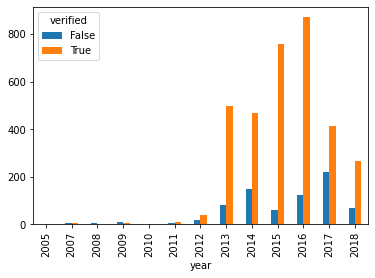

In [27]:
#verified rating vs non verified rating trends over the years
rating = reviews.groupby(['year', 'verified'])['overall'].count().unstack('verified').fillna(0)
rating.plot(kind='bar', stacked=False)

Interference: No of verified users are really high in the recent years but no of unverified users have also increased in the yaer 2017 and 2018 while the number of verified users have gone down.

In [28]:
rating_counts = pd.DataFrame(reviews['overall'].value_counts()).reset_index()
rating_counts.columns = ['Labels', 'Ratings']
rating_counts

,Labels,Ratings
0,5,3611
1,4,262
2,1,92
3,3,76
4,2,51


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


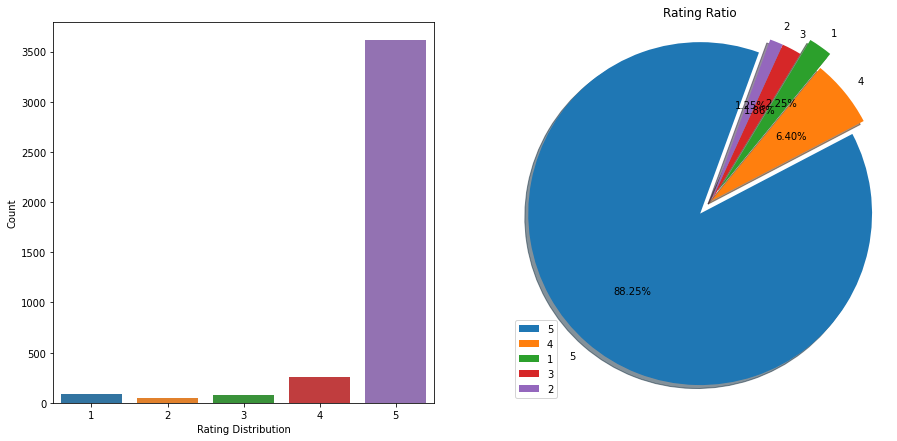

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.countplot(reviews['overall'], ax=ax1)
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)


explode = (0.1, 0, 0.1, 0, 0)
ax2.pie(rating_counts["Ratings"], explode=explode, labels=rating_counts.Labels, autopct='%1.2f%%',
        shadow=True, startangle=70)
ax2.axis('equal')
plt.title("Rating Ratio")
plt.legend(rating_counts.Labels, loc=3)
plt.show()

Interference: From the barplot and pie chart we can clearly see that approx 88% of data have 5 rating followed by 4(approx 6%). Least number of people have given 2 rating. One important insight is coming from here that most of the products are liked by the customers.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


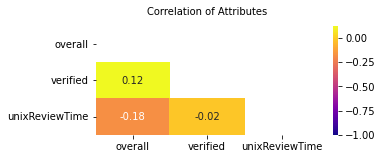

In [30]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,2))
plt.title('Correlation of Attributes', y=1.05, size=10)
sns.heatmap(df.corr(),vmin=-1, cmap='plasma',annot=True,  mask=mask, fmt='.2f')

Interference: We don't have many qualities, thus if we look at the correlation between rating, verified/unverified user, and timestamp, we won't find anything significant.

# ***ML Models Implementation Start*** 

*Data Preprocessing for model implementation*

In [31]:
reviews_backup = reviews
newRevId_reviews = reviews_backup.assign(id=(reviews_backup['reviewerID']).astype('category').cat.codes)
newRevId_reviews.rename(columns = {'id':'newRevId'}, inplace = True)
# newRevId_reviews


newProdId_reviews = reviews.assign(id=(reviews['asin']).astype('category').cat.codes)
newProdId_reviews.rename(columns = {'id':'newProdId'}, inplace = True)
# newProdId_reviews

# # reviews_backup[['reviewerID','asin','id']].head(20)

#Find the columns that aren't in the first DataFrame 
diff_cols = newProdId_reviews.columns.difference(newRevId_reviews.columns)
# diff_cols

# #Filter out the columns that are different. You could pass in the df2[diff_cols] directly into the merge as well.
df3 = newProdId_reviews[diff_cols]

# #Merge the DataFrames
df_final= pd.merge(newRevId_reviews, df3, left_index=True, right_index=True, how='inner')

#dropping last two columns containing image URLs which will not be required for analysis
df_final.drop(['imageURL', 'imageURLHighRes'],axis=1,inplace=True)
 
df_final.head()
# df_final[['reviewerID','asin','newRevId','newProdId','title']]

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,year,month,newRevId,newProdId
4354,5,True,"09 28, 2014",AZRD4IZU6TBFV,B0012Y0ZG2,{'Size:': ' 200'},Norma Gandy,Like this product very much..it smells great.,Five Stars,1411862400,NaN,NaN,[],,"[, , <b>Bath & Body Works Ile De Tahiti Moana ...",,Bath &amp; Body Works Ile De Tahiti Moana Coco...,[],,Bath & Body Works,[],"1,279,015 in Beauty & Personal Care (",[],"{' Item Weight: ': '8.5 ounces', 'Shi...",All Beauty,,,,2014,9,990,29
2463,5,True,"09 28, 2014",AZRD4IZU6TBFV,B000URXP6E,{'Size:': ' 200'},Norma Gandy,Like this product very much..it smells great.,Five Stars,1411862400,NaN,NaN,[],,[Juicy burst of Starburst fruit flavored Lip S...,,Bonne Bell Smackers Bath and Body Starburst Co...,[],,Bonne Bell,[],"1,390,827 in Beauty &amp; Personal Care (",[],"{'Shipping Weight:': '1.8 pounds', 'Domestic S...",All Beauty,,,,2014,9,990,13
1619,5,True,"09 28, 2014",AZRD4IZU6TBFV,B000FI4S1E,NaN,Norma Gandy,Like this product very much..it smells great.,Five Stars,1411862400,NaN,NaN,[],,[Fruits &amp; Passion SOLSTIS Refreshing Showe...,,Fruits &amp; Passion Blue Refreshing Shower Ge...,[],,Fruits & Passion,[],"2,539,624 in Beauty & Personal Care (",[],"{'Shipping Weight:': '8 ounces', 'ASIN: ': 'B0...",All Beauty,,,,2014,9,990,6
1226,5,True,"09 28, 2014",AZRD4IZU6TBFV,B0009RF9DW,{'Size:': ' 200'},Norma Gandy,Like this product very much..it smells great.,Five Stars,1411862400,NaN,NaN,[],,[<P><STRONG>With exfoliating grapefruit extrac...,,Yardley By Yardley Of London Unisexs Lay It On...,[],,Yardley,[],"1,906,056 in Beauty & Personal Care (",[],"{'ASIN: ': 'B0009RF9DW', 'UPC:': '041840822513'}",All Beauty,,,,2014,9,990,5
5170,5,True,"12 20, 2013",AZJMUP77WBQZQ,B001OHV1H4,{'Size:': ' 329'},S. Foote,THIS WAS A GIFT PURCHASED LAST YEAR FOR MY DAU...,GIFT,1387497600,NaN,NaN,[],,[It's in our name: Avalon Organics. Our commit...,,Avalon Grapefruit and Geranium Smoothing Shamp...,[],,Avalon,[],"643,961 in Beauty & Personal Care (",[],{' Product Dimensions: ': '7.2 x 3 x ...,All Beauty,,,,2013,12,989,40


# ***ALS MODEL IMPLEMENTATION***

In [32]:
nd=df_final[['asin','overall','reviewerID']]
spark = SparkSession.builder.appName('AmazonProduct_Recommendation').getOrCreate()
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
spark_dff = sqlContext.createDataFrame(nd)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


*Creating index columns for reviewerID and asin(productId) columns as they are currently alphanumeric*

In [33]:
indexing_cols = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in list(set(spark_dff.columns)-set(['overall'])) ]
pipeline = Pipeline(stages=indexing_cols)
transformed = pipeline.fit(spark_dff).transform(spark_dff)
transformed.show()

+----------+-------+-------------+----------------+----------+
|      asin|overall|   reviewerID|reviewerID_index|asin_index|
+----------+-------+-------------+----------------+----------+
|B0012Y0ZG2|      5|AZRD4IZU6TBFV|           933.0|       0.0|
|B000URXP6E|      5|AZRD4IZU6TBFV|           933.0|       1.0|
|B000FI4S1E|      5|AZRD4IZU6TBFV|           933.0|       5.0|
|B0009RF9DW|      5|AZRD4IZU6TBFV|           933.0|       4.0|
|B001OHV1H4|      5|AZJMUP77WBQZQ|           932.0|       3.0|
|B0012Y0ZG2|      5|AZJMUP77WBQZQ|           932.0|       0.0|
|B000URXP6E|      5|AZJMUP77WBQZQ|           932.0|       1.0|
|B00006L9LC|      5|AZJMUP77WBQZQ|           932.0|       2.0|
|B001OHV1H4|      5|AZFYUPGEE6KLW|           931.0|       3.0|
|B0012Y0ZG2|      5|AZFYUPGEE6KLW|           931.0|       0.0|
|B000URXP6E|      5|AZFYUPGEE6KLW|           931.0|       1.0|
|B00006L9LC|      5|AZFYUPGEE6KLW|           931.0|       2.0|
|B0012Y0ZG2|      5|AZD3ON9ZMEGL6|           930.0|    

*Splitting data into test and train datasets*

In [34]:
(training,test)=transformed.randomSplit([0.8, 0.2])
als=ALS(maxIter=5,regParam=0.09,rank=25,userCol="reviewerID_index",itemCol="asin_index",ratingCol="overall",coldStartStrategy="drop",nonnegative=True)
model=als.fit(training)

In [35]:
print('Factorized user matrix with rank = %d' % model.rank)
model.userFactors.show(5)
print('Factorized item matrix with rank = %d' % model.rank)
model.itemFactors.show(5)

Factorized user matrix with rank = 25


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+---+--------------------+
| id|            features|
+---+--------------------+
|  0|[0.30278596, 0.08...|
| 10|[6.7723973E-4, 0....|
| 20|[8.8114035E-4, 0....|
| 30|[5.4291326E-5, 0....|
| 40|[1.7676936E-4, 0....|
+---+--------------------+
only showing top 5 rows

Factorized item matrix with rank = 25
+---+--------------------+
| id|            features|
+---+--------------------+
|  0|[1.5729565E-4, 0....|
| 10|[0.0, 0.11178368,...|
| 20|[0.92985463, 0.64...|
| 30|[0.9322075, 0.232...|
| 40|[0.0, 0.089975014...|
+---+--------------------+
only showing top 5 rows



In [36]:
# user_recs=model.recommendForAllUsers(20).show(10) #Returns top numItems items recommended for each user, for all users.

In [37]:
print('Recommended top users (e.g. 1 top user) for all items with the corresponding predicted ratings:')
model.recommendForAllItems(5).show(5)
print('Recommended top items (e.g. 1 top item) for all users with the corresponding predicted ratings:')
model.recommendForAllUsers(5).show(5)

Recommended top users (e.g. 1 top user) for all items with the corresponding predicted ratings:


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+----------+--------------------+
|asin_index|     recommendations|
+----------+--------------------+
|        20|[{954, 5.4051795}...|
|        40|[{72, 4.7467403},...|
|        10|[{72, 4.7098308},...|
|        50|[{519, 4.8870873}...|
|        80|[{72, 8.06197}, {...|
+----------+--------------------+
only showing top 5 rows

Recommended top items (e.g. 1 top item) for all users with the corresponding predicted ratings:
+----------------+--------------------+
|reviewerID_index|     recommendations|
+----------------+--------------------+
|               1|[{62, 4.499309}, ...|
|               3|[{62, 5.133136}, ...|
|               5|[{62, 5.923374}, ...|
|               6|[{83, 4.8286157},...|
|               9|[{62, 5.041071}, ...|
+----------------+--------------------+
only showing top 5 rows



*Testing model performance on test data using the RMSE value*

In [38]:
predictions = model.transform(test)
predictions.show()

+----------+-------+--------------+----------------+----------+----------+
|      asin|overall|    reviewerID|reviewerID_index|asin_index|prediction|
+----------+-------+--------------+----------------+----------+----------+
|B00006L9LC|      5|  A7COTFQZZ86N|           148.0|       2.0| 4.6360955|
|B00006L9LC|      5|A3T1HGP5MN7OB6|           737.0|       2.0| 4.1264963|
|B000URXP6E|      5| ASUIA1YIKZUOO|           897.0|       1.0|  4.853574|
|B001OHV1H4|      5|A39IK7T2K2V2KA|           623.0|       3.0|  4.500092|
|B001OHV1H4|      5|A3T1HGP5MN7OB6|           737.0|       3.0|  4.101941|
|B00006L9LC|      5| ADNBIWDCIZJ0S|           808.0|       2.0| 4.1264963|
|B001OHV1H4|      5|A30EPPTPW7M9D0|           580.0|       3.0|  4.500092|
|B001OHV1H4|      5| ADNBIWDCIZJ0S|           808.0|       3.0|  4.101941|
|B00W259T7G|      5| AOTMP0OKJOUWI|           879.0|       6.0|  4.338165|
|B0009RF9DW|      5| ABXNHW16GPL6F|           799.0|       4.0| 4.8029165|
|B000URXP6E|      5| ABXN

In [39]:
evaluator = RegressionEvaluator(metricName='rmse', predictionCol='prediction', labelCol='overall')
rmse = evaluator.evaluate(predictions)
print('Root mean squared error of the test_data: %.4f' % rmse)

Root mean squared error of the test_data: 0.5686


In [40]:
user_history = training.filter(training['reviewerID_index']==11)
user_history.show()

+----------+-------+--------------+----------------+----------+
|      asin|overall|    reviewerID|reviewerID_index|asin_index|
+----------+-------+--------------+----------------+----------+
|B000GLRREU|      5|A25C2M3QF9G7OQ|            11.0|      15.0|
|B000NKJIXM|      2|A25C2M3QF9G7OQ|            11.0|      16.0|
|B001F51RAG|      5|A25C2M3QF9G7OQ|            11.0|      55.0|
|B00W259T7G|      5|A25C2M3QF9G7OQ|            11.0|       6.0|
+----------+-------+--------------+----------------+----------+



In [41]:
user_suggest = test.filter(training['reviewerID_index']==11).select(['asin_index', 'reviewerID_index','asin','reviewerID','overall'])
user_suggest.show()

+----------+----------------+----------+--------------+-------+
|asin_index|reviewerID_index|      asin|    reviewerID|overall|
+----------+----------------+----------+--------------+-------+
|      14.0|            11.0|B000FOI48G|A25C2M3QF9G7OQ|      5|
|      24.0|            11.0|B002GP80EU|A25C2M3QF9G7OQ|      5|
+----------+----------------+----------+--------------+-------+



In [42]:
user_offer = model.transform(user_suggest)
user_offer.orderBy('prediction', ascending=False).show()

+----------+----------------+----------+--------------+-------+----------+
|asin_index|reviewerID_index|      asin|    reviewerID|overall|prediction|
+----------+----------------+----------+--------------+-------+----------+
|      14.0|            11.0|B000FOI48G|A25C2M3QF9G7OQ|      5| 4.5388713|
|      24.0|            11.0|B002GP80EU|A25C2M3QF9G7OQ|      5| 3.8954542|
+----------+----------------+----------+--------------+-------+----------+



*Calculate Mean Absolute Error to predict ratings*

In [43]:
evaluator_mae=RegressionEvaluator(metricName="mae",labelCol="overall",predictionCol="prediction")
predictions=model.transform(test)
mae=evaluator_mae.evaluate(predictions)
print("MAE (using ALS )= "+str(mae))
predictions.show()

MAE (using ALS )= 0.37670666839902767
+----------+-------+--------------+----------------+----------+----------+
|      asin|overall|    reviewerID|reviewerID_index|asin_index|prediction|
+----------+-------+--------------+----------------+----------+----------+
|B00006L9LC|      5|  A7COTFQZZ86N|           148.0|       2.0| 4.6360955|
|B00006L9LC|      5|A3T1HGP5MN7OB6|           737.0|       2.0| 4.1264963|
|B000URXP6E|      5| ASUIA1YIKZUOO|           897.0|       1.0|  4.853574|
|B001OHV1H4|      5|A39IK7T2K2V2KA|           623.0|       3.0|  4.500092|
|B001OHV1H4|      5|A3T1HGP5MN7OB6|           737.0|       3.0|  4.101941|
|B00006L9LC|      5| ADNBIWDCIZJ0S|           808.0|       2.0| 4.1264963|
|B001OHV1H4|      5|A30EPPTPW7M9D0|           580.0|       3.0|  4.500092|
|B001OHV1H4|      5| ADNBIWDCIZJ0S|           808.0|       3.0|  4.101941|
|B00W259T7G|      5| AOTMP0OKJOUWI|           879.0|       6.0|  4.338165|
|B0009RF9DW|      5| ABXNHW16GPL6F|           799.0|       4.0

In [44]:
user_history = training.filter(training['reviewerID_index']==11)
user_history.show()

+----------+-------+--------------+----------------+----------+
|      asin|overall|    reviewerID|reviewerID_index|asin_index|
+----------+-------+--------------+----------------+----------+
|B000GLRREU|      5|A25C2M3QF9G7OQ|            11.0|      15.0|
|B000NKJIXM|      2|A25C2M3QF9G7OQ|            11.0|      16.0|
|B001F51RAG|      5|A25C2M3QF9G7OQ|            11.0|      55.0|
|B00W259T7G|      5|A25C2M3QF9G7OQ|            11.0|       6.0|
+----------+-------+--------------+----------------+----------+



In [45]:
# normalised_mat = ratings_mat - np.asarray([(np.mean(ratings_mat, 1))]).T
# normalised_mat

# ***Single Value Decomposition Implementation***

In [46]:
sparse_mat = df_final.pivot(index="newRevId", columns="newProdId", values="overall").fillna(0).astype(int)
sparse_mat

newProdId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
newRevId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,5,5,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,5,5,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,5,0,0,0,0,0,0
3,0,0,0,0,0,5,5,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,5,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,0,5,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
987,0,0,0,0,0,5,5,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
988,0,5,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
# A = normalised_mat.T / np.sqrt(ratings_mat.shape[0] - 1)
U, S, V = np.linalg.svd(sparse_mat,full_matrices=False)
S = np.diag(S)

In [48]:
def calc_cosine_similarity(df, newProdId, top_n=10):
    prod_row = df[newProdId - 1 , :] # Product id starts from 0 in the dataset
    magnitude = np.sqrt(np.einsum('ij, ij -> i', df, df))
    similarity = np.dot(prod_row, df.T) / (magnitude[newProdId - 1] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

def similar_products(df, newProdId, top_indexes):
    print('Recommendations for {0}: \n'.format(
    df[df.newProdId == newProdId].title.values[0]))
    for id in top_indexes + 1:
        print(df[df.newProdId == id].title.values[0])

*Generating recommendations using cosine similarities*

In [49]:
product_id = 1 #generating recommendations for product_id 1 with 5 principal components
sliced = V.T[:, :5] #5 represents the number of principal components
indexes = calc_cosine_similarity(sliced, product_id, 5)
similar_products(df_final, product_id, indexes)

Recommendations for Citre Shine Moisture Burst Shampoo - 16 fl oz: 

Citre Shine Moisture Burst Shampoo - 16 fl oz
Waterpik Ultra Water Flosser
Urban Spa Natural Bamboo and Jute Bath Mitt
Clean &amp; Clear Deep Action Cream Facial Cleanser for Sensitive Skin, Gentle Daily Face Wash with Oil-Free, 6.5 oz (Pack of 4)
FusionBeauty LiftFusion Face Lift


In [50]:
product_id = 20 #generating recommendations for product_id 20 with 5 principal components
sliced = V.T[:, :5]
indexes = calc_cosine_similarity(sliced, product_id, 5)
similar_products(df_final,product_id,indexes)

Recommendations for Dr. Woods Pure Almond Liquid Castile Soap, 32 Ounce: 

Dr. Woods Pure Almond Liquid Castile Soap, 32 Ounce
Organic Fiji  Raw Organic Coconut Oil, 13-Ounce Jars
Fruits &amp; Passion Blue Refreshing Shower Gel - 6.7 fl. oz.
Waterpik Ultra Water Flosser
Spongelle Wild Flower 14+ Uses Body Wash Buffer, French Lavender, 4.25&quot; x 1.25&quot;


In [51]:
product_id = 40 #generating recommendations for product_id 40 with 5 principal components
sliced = V.T[:, :5]
indexes = calc_cosine_similarity(sliced, product_id, 10)
similar_products(df_final,5, indexes)

Recommendations for Yardley By Yardley Of London Unisexs Lay It On Thick Hand &amp; Foot Cream 5.3 Oz: 

Avalon Grapefruit and Geranium Smoothing Shampoo, 11 Ounce
Ultimate Body Lotion By Michael Kors 3.4oz
Helen of Troy 1579 Tangle Free Hot Air Brush, White, 3/4 Inch Barrel
Sex In The City Kiss by Instyle Parfums Eau De Parfum Spray 3.4 oz
Bonne Bell Smackers Bath and Body Starburst Collection
Maggie's Functional Organics Raspberry Navy Forest 9-11
Nag Champa Super Hit Cones, 144 Cones Box
Hammam El Hana Argan Therapy Egyptian White Musk Body Lotion 13.5 Fl.Oz. From Turkey
Fekkai Full Blown Aerosol Foam Cond Us 6.6 Oz, 6.660-Fluid Ounce
PLANTLIFE Sandalwood Soap Bar, 4 Ounce


In [52]:
product_id = 29 #generating recommendations for product_id 40 with 10 principal components
sliced = V.T[:, :10] 
indexes = calc_cosine_similarity(sliced, product_id, 10)
similar_products(df_final,5, indexes)

Recommendations for Yardley By Yardley Of London Unisexs Lay It On Thick Hand &amp; Foot Cream 5.3 Oz: 

Bath &amp; Body Works Ile De Tahiti Moana Coconut Vanille Moana Body Wash with Tamanoi 8.5 oz
Peter Lamas Wheatgrass Purifying Shampoo and Conditioner Set, 12 Fluid Ounce Each
EO Shower Gel Grapefruit &amp; Mint 32 oz
BVLGARI WHITE by Bvlgari for Men and Women: SHAMPOO 6.8 OZ
Pre de Provence Maison French Dried Lavender Blossoms for Fragrance
Toni&amp;Guy Glamour Volume Plumping Whip, 2.82 Fluid Ounce
Andalou Naturals Clementine + C Illuminating Toner, 6 Fl oz, Facial Toner Helps Hydrate &amp; Balance Skin pH, For Clear, Bright Skin
Theorie Argan Oil Ultimate Reform Shampoo &amp; Conditioner 27 Fl Oz Each
Fresh Eau de Parfum, Sugar Lemon, 3.4 oz
Aqua Velva After Shave, Classic Ice Blue, 3.5 Ounce


In [53]:
#Cosine similarity matrix
cosine_sim = 1-pairwise_distances(sparse_mat, metric="cosine")
pd.DataFrame(cosine_sim)

0    1    2    3    4         5    6    7    8    9         10   \
0    1.0  1.0  0.0  1.0  0.5  0.447214  1.0  0.5  0.5  0.0  0.000000   
1    1.0  1.0  0.0  1.0  0.5  0.447214  1.0  0.5  0.5  0.0  0.000000   
2    0.0  0.0  1.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.524142   
3    1.0  1.0  0.0  1.0  0.5  0.447214  1.0  0.5  0.5  0.0  0.000000   
4    0.5  0.5  0.0  0.5  1.0  0.894427  0.5  1.0  1.0  0.0  0.000000   
..   ...  ...  ...  ...  ...       ...  ...  ...  ...  ...       ...   
986  0.5  0.5  0.0  0.5  1.0  0.894427  0.5  1.0  1.0  0.0  0.000000   
987  1.0  1.0  0.0  1.0  0.5  0.447214  1.0  0.5  0.5  0.0  0.000000   
988  0.5  0.5  0.0  0.5  1.0  0.894427  0.5  1.0  1.0  0.0  0.000000   
989  0.5  0.5  0.0  0.5  1.0  0.894427  0.5  1.0  1.0  0.0  0.000000   
990  1.0  1.0  0.0  1.0  0.5  0.447214  1.0  0.5  0.5  0.0  0.000000   

          11   12   13   14   15   16   17   18        19   20   21   22   \
0    0.894427  0.5  0.5  0.5  0.5  0.5  1.0  0.5  0.894427  1.0  0.5  1.0   
1    0.894427  0.5  0.5  0.5  0.5  0.5  1.0  0.5  0.894427  1.0  0.5  1.0   
2    0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
3    0.894427  0.5  0.5  0.5  0.5  0.5  1.0  0.5  0.894427  1.0  0.5  1.0   
4    0.447214  1.0  1.0  1.0  1.0  1.0  0.5  1.0  0.447214  0.5  1.0  0.5   
..        ...  ...  ...  ...  ...  ...  ...  ...       ...  ...  ...  ...   
986  0.447214  1.0  1.0  1.0  1.0  1.0  0.5  1.0  0.447214  0.5  1.0  0.5   
987  0.894427  0.5  0.5  0.5  0.5  0.5  1.0  0.5  0.894427  1.0  0.5  1.0   
988  0.447214  1.0  1.0  1.0  1.0  1.0  0.5  1.0  0.447214  0.5  1.0  0.5   
989  0.447214  1.0  1.0  1.0  1.0  1.0  0.5  1.0  0.447214  0.5  1.0  0.5   
990  0.894427  0.5  0.5  0.5  0.5  0.5  1.0  0.5  0.894427  1.0  0.5  1.0   

     23   24   25   26   27   28   29   30   31   32   33        34   35   \
0    0.5  1.0  1.0  0.5  0.5  1.0  1.0  1.0  1.0  0.5  0.5  0.894427  1.0   
1    0.5  1.0  1.0  0.5  0.5  1.0  1.0  1.0  1.0  0.5  0.5  0.894427  1.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
3    0.5  1.0  1.0  0.5  0.5  1.0  1.0  1.0  1.0  0.5  0.5  0.894427  1.0   
4    1.0  0.5  0.5  1.0  1.0  0.5  0.5  0.5  0.5  1.0  1.0  0.447214  0.5   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...   
986  1.0  0.5  0.5  1.0  1.0  0.5  0.5  0.5  0.5  1.0  1.0  0.447214  0.5   
987  0.5  1.0  1.0  0.5  0.5  1.0  1.0  1.0  1.0  0.5  0.5  0.894427  1.0   
988  1.0  0.5  0.5  1.0  1.0  0.5  0.5  0.5  0.5  1.0  1.0  0.447214  0.5   
989  1.0  0.5  0.5  1.0  1.0  0.5  0.5  0.5  0.5  1.0  1.0  0.447214  0.5   
990  0.5  1.0  1.0  0.5  0.5  1.0  1.0  1.0  1.0  0.5  0.5  0.894427  1.0   

          36   37   38   39        40   41   42        43        44   45   \
0    0.524142  1.0  0.5  0.5  0.000000  1.0  0.5  0.447214  0.000000  1.0   
1    0.524142  1.0  0.5  0.5  0.000000  1.0  0.5  0.447214  0.000000  1.0   
2    0.000000  0.0  0.0  0.0  0.851631  0.0  0.0  0.000000  0.302614  0.0   
3    0.524142  1.0  0.5  0.5  0.000000  1.0  0.5  0.447214  0.000000  1.0   
4    0.000000  0.5  1.0  1.0  0.000000  0.5  1.0  0.894427  0.000000  0.5   
..        ...  ...  ...  ...       ...  ...  ...       ...       ...  ...   
986  0.000000  0.5  1.0  1.0  0.000000  0.5  1.0  0.894427  0.000000  0.5   
987  0.524142  1.0  0.5  0.5  0.000000  1.0  0.5  0.447214  0.000000  1.0   
988  0.000000  0.5  1.0  1.0  0.000000  0.5  1.0  0.894427  0.000000  0.5   
989  0.000000  0.5  1.0  1.0  0.000000  0.5  1.0  0.894427  0.000000  0.5   
990  0.524142  1.0  0.5  0.5  0.000000  1.0  0.5  0.447214  0.000000  1.0   

     46   47   48   49   50   51   52   53   54   55        56        57   \
0    0.5  1.0  0.5  0.5  0.5  0.5  1.0  1.0  1.0  0.5  0.447214  0.447214   
1    0.5  1.0  0.5  0.5  0.5  0.5  1.0  1.0  1.0  0.5  0.447214  0.447214   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000   
3    0.5  1.0  0.5  0.5  0.5  0.5  1.0  1.0  1.0  0.5  0.

In [54]:
#Pearson correlation similarity matrix
pearson_sim = 1-pairwise_distances(sparse_mat, metric="correlation")
pd.DataFrame(pearson_sim)

0         1         2         3         4         5         6    \
0    1.000000  1.000000 -0.049169  1.000000  0.475309  0.416667  1.000000   
1    1.000000  1.000000 -0.049169  1.000000  0.475309  0.416667  1.000000   
2   -0.049169 -0.049169  1.000000 -0.049169 -0.049169 -0.055315 -0.049169   
3    1.000000  1.000000 -0.049169  1.000000  0.475309  0.416667  1.000000   
4    0.475309  0.475309 -0.049169  0.475309  1.000000  0.888889  0.475309   
..        ...       ...       ...       ...       ...       ...       ...   
986  0.475309  0.475309 -0.049169  0.475309  1.000000  0.888889  0.475309   
987  1.000000  1.000000 -0.049169  1.000000  0.475309  0.416667  1.000000   
988  0.475309  0.475309 -0.049169  0.475309  1.000000  0.888889  0.475309   
989  0.475309  0.475309 -0.049169  0.475309  1.000000  0.888889  0.475309   
990  1.000000  1.000000 -0.049169  1.000000  0.475309  0.416667  1.000000   

          7         8         9         10        11        12        13   \
0    0.475309  0.475309 -0.024246 -0.024246  0.888889  0.475309  0.475309   
1    0.475309  0.475309 -0.024246 -0.024246  0.888889  0.475309  0.475309   
2   -0.049169 -0.049169 -0.024141  0.515864 -0.055315 -0.049169 -0.049169   
3    0.475309  0.475309 -0.024246 -0.024246  0.888889  0.475309  0.475309   
4    1.000000  1.000000 -0.024246 -0.024246  0.416667  1.000000  1.000000   
..        ...       ...       ...       ...       ...       ...       ...   
986  1.000000  1.000000 -0.024246 -0.024246  0.416667  1.000000  1.000000   
987  0.475309  0.475309 -0.024246 -0.024246  0.888889  0.475309  0.475309   
988  1.000000  1.000000 -0.024246 -0.024246  0.416667  1.000000  1.000000   
989  1.000000  1.000000 -0.024246 -0.024246  0.416667  1.000000  1.000000   
990  0.475309  0.475309 -0.024246 -0.024246  0.888889  0.475309  0.475309   

          14        15        16        17        18        19        20   \
0    0.475309  0.475309  0.475309  1.000000  0.475309  0.888889  1.000000   
1    0.475309  0.475309  0.475309  1.000000  0.475309  0.888889  1.000000   
2   -0.049169 -0.049169 -0.049169 -0.049169 -0.049169 -0.055315 -0.049169   
3    0.475309  0.475309  0.475309  1.000000  0.475309  0.888889  1.000000   
4    1.000000  1.000000  1.000000  0.475309  1.000000  0.416667  0.475309   
..        ...       ...       ...       ...       ...       ...       ...   
986  1.000000  1.000000  1.000000  0.475309  1.000000  0.416667  0.475309   
987  0.475309  0.475309  0.475309  1.000000  0.475309  0.888889  1.000000   
988  1.000000  1.000000  1.000000  0.475309  1.000000  0.416667  0.475309   
989  1.000000  1.000000  1.000000  0.475309  1.000000  0.416667  0.475309   
990  0.475309  0.475309  0.475309  1.000000  0.475309  0.888889  1.000000   

          21        22        23        24        25        26        27   \
0    0.475309  1.000000  0.475309  1.000000  1.000000  0.475309  0.475309   
1    0.475309  1.000000  0.475309  1.000000  1.000000  0.475309  0.475309   
2   -0.049169 -0.049169 -0.049169 -0.049169 -0.049169 -0.049169 -0.049169   
3    0.475309  1.000000  0.475309  1.000000  1.000000  0.475309  0.475309   
4    1.000000  0.475309  1.000000  0.475309  0.475309  1.000000  1.000000   
..        ...       ...       ...       ...       ...       ...       ...   
986  1.000000  0.475309  1.000000  0.475309  0.475309  1.000000  1.000000   
987  0.475309  1.000000  0.475309  1.000000  1.000000  0.475309  0.475309   
988  1.000000  0.475309  1.000000  0.475309  0.475309  1.000000  1.000000   
989  1.000000  0.475309  1.000000  0.475309  0.475309  1.000000  1.000000   
990  0.475309  1.000000  0.475309  1.000000  1.000000  0.475309  0.475309   

          28        29        30        31        32        33        34   \
0    1.000000  1.000000  1.000000  1.000000  0.475309  0.475309  0.888889   
1    1.000000  1.000000  1.000000  1.000000  0.475309  0.475309  0.888889   
2   -0.049169 -0.049169 -0.049169 -0.049169 -0.049169 -0.049169 -0.055315   
3 

*This function take user_id, sparse matrix and metric which is by default cosine and generates k similar users*

In [55]:
k=5
metric='cosine'
def findksimilarusers(user_id, ratings, metric = metric, k=k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)

    distance, indices = model_knn.kneighbors(ratings.iloc[user_id-1, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distance.flatten()
    print(k,'most similar users for User',user_id,':\n')
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == user_id:
            continue;

        else:
            print(i, 'User', indices.flatten()[i]+1, 'with similarity of', similarities.flatten()[i])
            
    return similarities,indices

In [56]:
similarities,indices = findksimilarusers(1,sparse_mat, metric='cosine')

5 most similar users for User 1 :

0 User 491 with similarity of 1.0
1 User 486 with similarity of 1.0
2 User 500 with similarity of 1.0
3 User 487 with similarity of 1.0
4 User 511 with similarity of 1.0
5 User 2 with similarity of 1.0


In [57]:
similarities,indices = findksimilarusers(10,sparse_mat, metric='correlation')

5 most similar users for User 10 :

0 User 959 with similarity of 1.0
2 User 489 with similarity of -0.011904761904761862
3 User 695 with similarity of -0.011904761904761862
4 User 100 with similarity of -0.011904761904761862
5 User 876 with similarity of -0.011904761904761862


*Predicting rating for specified user-item combination based on user-based approach*

In [58]:
def predict_userbased(user_id, item_id, ratings, metric = metric, k=k):
    prediction=0
    similarity, indexes=findksimilarusers(user_id, ratings,metric, k) #similar users based on cosine similarity
    mean_rating = ratings.loc[user_id-1,:].mean() #to adjust for zero based indexing
    sum_wt = np.sum(similarity)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indexes.flatten())):
        if indexes.flatten()[i]+1 == user_id:
            continue;
        else: 
            ratings_diff = ratings.iloc[indexes.flatten()[i],item_id-1]-np.mean(ratings.iloc[indexes.flatten()[i],:])
            product = ratings_diff * (similarity[i])
            wtd_sum = wtd_sum + product
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print('\nPredicted rating for user',user_id,'-> item',item_id,':',prediction)

    return prediction

In [59]:
predict_userbased(3,70,sparse_mat)

5 most similar users for User 3 :

1 User 636 with similarity of 0.9078412990032037
2 User 426 with similarity of 0.9078412990032037
3 User 946 with similarity of 0.9032446046618912
4 User 812 with similarity of 0.8594799233872417
5 User 41 with similarity of 0.8516306272526402

Predicted rating for user 3 -> item 70 : 0


0

In [60]:
predict_userbased(20,46,sparse_mat)

5 most similar users for User 20 :

0 User 778 with similarity of 0.9999999999999999
1 User 196 with similarity of 0.9999999999999999
2 User 833 with similarity of 0.9999999999999999
3 User 367 with similarity of 0.9999999999999999
4 User 171 with similarity of 0.9999999999999999
5 User 298 with similarity of 0.9999999999999999

Predicted rating for user 20 -> item 46 : 0


0

*Generate k similar items given the item_id and ratings matrix M*

In [61]:
def findksimilaritems(item_id, ratings, metric=metric, k=k):
    similarities=[]
    indices=[]    
    ratings=ratings.T
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)

    distances, indices = model_knn.kneighbors(ratings.iloc[item_id-1, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    print('{0} most similar items for item {1}:\n'.format(k,item_id))
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == item_id:
            continue;

        else:
            print('{0}: Item {1} :, with similarity of {2}'.format(i,indices.flatten()[i]+1, similarities.flatten()[i]))


    return similarities,indices

In [62]:
similarities,indices=findksimilaritems(16,sparse_mat)

5 most similar items for item 16:

1: Item 11 :, with similarity of 0.7001400420140048
2: Item 59 :, with similarity of 0.0
3: Item 61 :, with similarity of 0.0
4: Item 58 :, with similarity of 0.0
5: Item 56 :, with similarity of 0.0


In [63]:
similarities,indices=findksimilaritems(62,sparse_mat)

5 most similar items for item 62:

1: Item 67 :, with similarity of 1.0
2: Item 29 :, with similarity of 1.0
3: Item 44 :, with similarity of 0.7071067811865475
4: Item 39 :, with similarity of 0.6154574548966636
5: Item 57 :, with similarity of 0.0


### *** KNN MODELS START***


In [64]:
reviews2 = reviews[['reviewerID', 'asin', 'overall']]
reviews2.shape

(4092, 3)

In [65]:
# Displaying the data
reviews2.head()

,reviewerID,asin,overall
4354,AZRD4IZU6TBFV,B0012Y0ZG2,5
2463,AZRD4IZU6TBFV,B000URXP6E,5
1619,AZRD4IZU6TBFV,B000FI4S1E,5
1226,AZRD4IZU6TBFV,B0009RF9DW,5
5170,AZJMUP77WBQZQ,B001OHV1H4,5


*Unique Users and products*

In [66]:
unique_users =len(np.unique(reviews2.reviewerID))
unique_pdts = len(np.unique(reviews2.asin))
print('Total number of users is: ',unique_users,'\n')
print('Total number of products is: ',unique_pdts,'\n')

Total number of users is:  991 

Total number of products is:  85 



In [67]:
dupes=reviews2.duplicated()
print(' The number of duplicates in the dataset are:',sum(dupes), '\n','There are no duplicates in the dataset')

 The number of duplicates in the dataset are: 0 
 There are no duplicates in the dataset


*To ensure that the amount of people offering better ratings has no bearing on our recommendations, let's keep the users who have given 50 or more ratings as an example for enhanced analysis.*

In [68]:
new_df=reviews2.groupby("asin").filter(lambda x:x['overall'].count() >= 50)

In [69]:
reader = Reader(rating_scale=(1, 5))

In [70]:
new_df2=Dataset.load_from_df(new_df[['reviewerID', 'asin', 'overall']],reader)
new_df2

In [71]:
#Top 5 products which have the highest ratings
new_df.groupby('asin')['overall'].mean().sort_values(ascending=False).head()

asin
B0009RF9DW    4.940415
B000FI4S1E    4.940415
B0012Y0ZG2    4.843070
B000URXP6E    4.838824
B00006L9LC    4.762781
Name: overall, dtype: float64

In [72]:
#The products which have been rated the most
new_df.groupby('asin')['overall'].count().sort_values(ascending=False).head()

asin
B0012Y0ZG2    873
B000URXP6E    850
B00006L9LC    489
B001OHV1H4    489
B0009RF9DW    386
Name: overall, dtype: int64

In [73]:
#Sorting the products in descending order based on the rating counts to find the products with the highest rating and the highest rating counts.
reviews2_product_ratings =pd.DataFrame(new_df.groupby('asin')['overall'].mean())
reviews2_product_ratings['ratings_count'] = pd.DataFrame(new_df.groupby('asin')['overall'].count())
reviews2_product_ratings.sort_values(by='ratings_count',ascending=False).head()

,overall,ratings_count
asin,,
B0012Y0ZG2,4.843070,873
B000URXP6E,4.838824,850
B00006L9LC,4.762781,489
B001OHV1H4,4.762781,489
B0009RF9DW,4.940415,386


*Split the data randomly into train and test dataset.*

In [74]:
trainset, testset = train_test_split(new_df2, test_size=0.3,random_state=1)

In [75]:
data = new_df2

In [76]:
#As, we use KNN algorithm for prediction. First we will select default parameters and check the RMSE. Post which we will use hyper parameters for tuning and arrive at the best parameters for our model
algo_knn = KNNWithMeans()
algo_knn.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [77]:
predictions_knn = algo_knn.test(testset)

***RMSE Value***

In [78]:
#Get RMSE
print("User-based Model : Test Set")
accuracy.rmse(predictions_knn, verbose=True)

User-based Model : Test Set
RMSE: 0.0913


0.09132878836173099

*We will use grid-search to arrive at the best hyper parameters.*

In [79]:
sim_options = {
    "name": ["msd", "cosine","pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [True],
    "k":[5,10,20,30,40,50,100]
    
}

In [80]:
param_grid = {"sim_options": sim_options,"verbose":[True,False]}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"],cv=5)
gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [81]:
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.12515385681866603
{'sim_options': {'name': 'msd', 'min_support': 4, 'user_based': True, 'k': 5}, 'verbose': True}


In [82]:
algo = KNNWithMeans(sim_options={'name': 'pearson_baseline', 'min_support': 5, 'user_based': False ,'k':5},verbose= True,c=3)
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [83]:
#running the trained model against the testset
predictions = algo.test(testset)
predictions

[Prediction(uid='A1JDBXPK20HBUW', iid='B000URXP6E', r_ui=5.0, est=5, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A29GCQQLNLUJGG', iid='B00006L9LC', r_ui=5.0, est=4.982362251665514, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A1N3KXBQ1A53IP', iid='B000URXP6E', r_ui=5.0, est=4.942737687480237, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A1TEIICSK5IK0V', iid='B0012Y0ZG2', r_ui=5.0, est=5, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A28F08XFZRKIH5', iid='B0009RF9DW', r_ui=1.0, est=1.03376891016842, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A2KZH1QYHRJRB7', iid='B000URXP6E', r_ui=5.0, est=4.942737687480237, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A2N52EPR60UCHN', iid='B00006L9LC', r_ui=5.0, est=5, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A1THB1R8LWTMPV', iid='B001OHV1H4', r_ui=5.0, est=4.924905521839588, details={'ac

*Evaluate the model.*

In [84]:
reviews2_product_ratings['score'] = reviews2_product_ratings['overall']*reviews2_product_ratings['ratings_count']

In [85]:
print('the top 5 recommendations are:') 
reviews2_product_ratings.sort_values(by='score',ascending=False).head()

the top 5 recommendations are:


,overall,ratings_count,score
asin,,,
B0012Y0ZG2,4.843070,873,4228.0
B000URXP6E,4.838824,850,4113.0
B00006L9LC,4.762781,489,2329.0
B001OHV1H4,4.762781,489,2329.0
B0009RF9DW,4.940415,386,1907.0


In [86]:
cross_validate(algo, new_df2, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# get RMSE
print('For the KNN Model, the accuracy of the Test Set is:')
accuracy.rmse(predictions, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1029  0.1030  0.1989  0.0669  0.1064  0.1156  0.0441  
MAE (testset)     0.0374  0.0367  0.0502  0.0346  0.0403  0.0398  0.0055  
Fit time          0.01    0.01    0.01    0.02    0.01    0.01    0.00    
Test time         0.01    0.01    0.01    0.01    0.

0.09301057915995789

*Lets identify the top recommendations for each user:*

In [87]:
def get_top_n(predictions,n=5):
  top_n=defaultdict(list)
  for uid,iid,true_r,est,_ in predictions:
    top_n[uid].append((iid,est))
  for uid,user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1],reverse=True)
    top_n[uid]=user_ratings[:n]
  return top_n

In [88]:
top_n=get_top_n(predictions)

In [89]:
print('top recommended products for each user are:')
top_n

top recommended products for each user are:


defaultdict(list,
            {'A10JB7YPWZGRF4': [('B0012Y0ZG2', 4.933293415618454)],
             'A10P0NAKKRYKTZ': [('B0009RF9DW', 5),
              ('B0012Y0ZG2', 4.948478773588673)],
             'A1118RD3AJD5KH': [('B00006L9LC', 4.982362251665514)],
             'A115LE3GBAO8I6': [('B0009RF9DW', 5),
              ('B000URXP6E', 4.95819485076181)],
             'A11AZPF8R6A1F8': [('B0012Y0ZG2', 5),
              ('B000URXP6E', 5),
              ('B001OHV1H4', 4.949449724404403)],
             'A11L1TI883AOSV': [('B0012Y0ZG2', 4.994373408319185),
              ('B00006L9LC', 4.946123034067687),
              ('B001OHV1H4', 4.89557275847209)],
             'A121C9UWQFW5W6': [('B0009RF9DW', 5),
              ('B000FI4S1E', 5),
              ('B0012Y0ZG2', 4.994373408319185)],
             'A125PSVY71Q7KZ': [('B001OHV1H4', 4.915263788238867)],
             'A12B5Y225ADJWE': [('B0012Y0ZG2', 5)],
             'A12BLGAAZBUU96': [('B00006L9LC', 5), ('B000URXP6E', 5)],
             'A12HTKL